<a href="https://colab.research.google.com/github/PGM-Lab/2022-ProbAI/blob/main/Day2-AfterLunch/notebooks/solution_simple_gaussian_model_pyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/PGM-Lab/2022-ProbAI/raw/main/Day2-AfterLunch/notebooks/Figures/simple_pyro_exercise.png">

In [ ]:
!pip install -q --upgrade pyro-ppl torch 

import numpy as np
import torch
from torch.distributions import constraints
import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Gamma, MultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.optim as optim

     |████████████████████████████████| 750.6 MB 10 kB/s 


## Generate some data

In [ ]:
# Sample data
np.random.seed(123)
N = 100
correct_mean = 5
correct_precision = 1
data = torch.tensor(np.random.normal(loc=correct_mean, scale=np.sqrt(1./correct_precision), size=N), dtype=torch.float)


## Our model specification

In [ ]:
def model(data):
    gamma = pyro.sample("gamma", Gamma(torch.tensor(1.), torch.tensor(1.)))
    mu = pyro.sample("mu", Normal(torch.zeros(1), torch.tensor(10000.0)))
    with pyro.plate("data", len(data)):
        pyro.sample("x", Normal(loc=mu, scale=torch.sqrt(1. / gamma)), obs=data)

## Our guide specification

In [ ]:
def guide(data=None):
    alpha_q = pyro.param("alpha_q", torch.tensor(1.), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(1.), constraint=constraints.positive)
    pyro.sample("gamma", Gamma(alpha_q, beta_q))

    mean_q = pyro.param("mean_q", torch.tensor(0.))
    scale_q = pyro.param("scale_q", torch.tensor(1.), constraint=constraints.positive)
    pyro.sample("mu", Normal(mean_q, scale_q))

## Do learning

In [ ]:
# setup the optimizer
adam_args = {"lr": 0.01}
optimizer = Adam(adam_args)

pyro.clear_param_store()
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
train_elbo = []
# training loop
for epoch in range(3000):
    loss = svi.step(data)
    train_elbo.append(-loss)
    if (epoch % 500) == 0:
        print("[epoch %03d] average training loss: %.4f" % (epoch, loss))

/usr/local/lib/python3.7/dist-packages/pyro/infer/svi.py:53: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  "number of iterations.",


[epoch 000] average training loss: 4678.7293
[epoch 500] average training loss: 277.2488
[epoch 1000] average training loss: 251.4889
[epoch 1500] average training loss: 217.9515
[epoch 2000] average training loss: 174.1540
[epoch 2500] average training loss: 165.9747


In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.numpy())

alphav 3.4341245
beta_q 4.0748396
mean_q 5.015445
scale_q 0.19180033


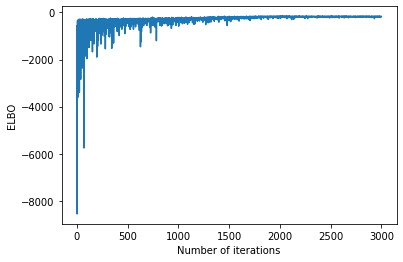

In [ ]:
plt.plot(range(len(train_elbo)), train_elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.show()